# Validação de modelos de clusterização

Aluna: Isabelle Rodrigues Vaz de Melo

## Ambiente virtual python

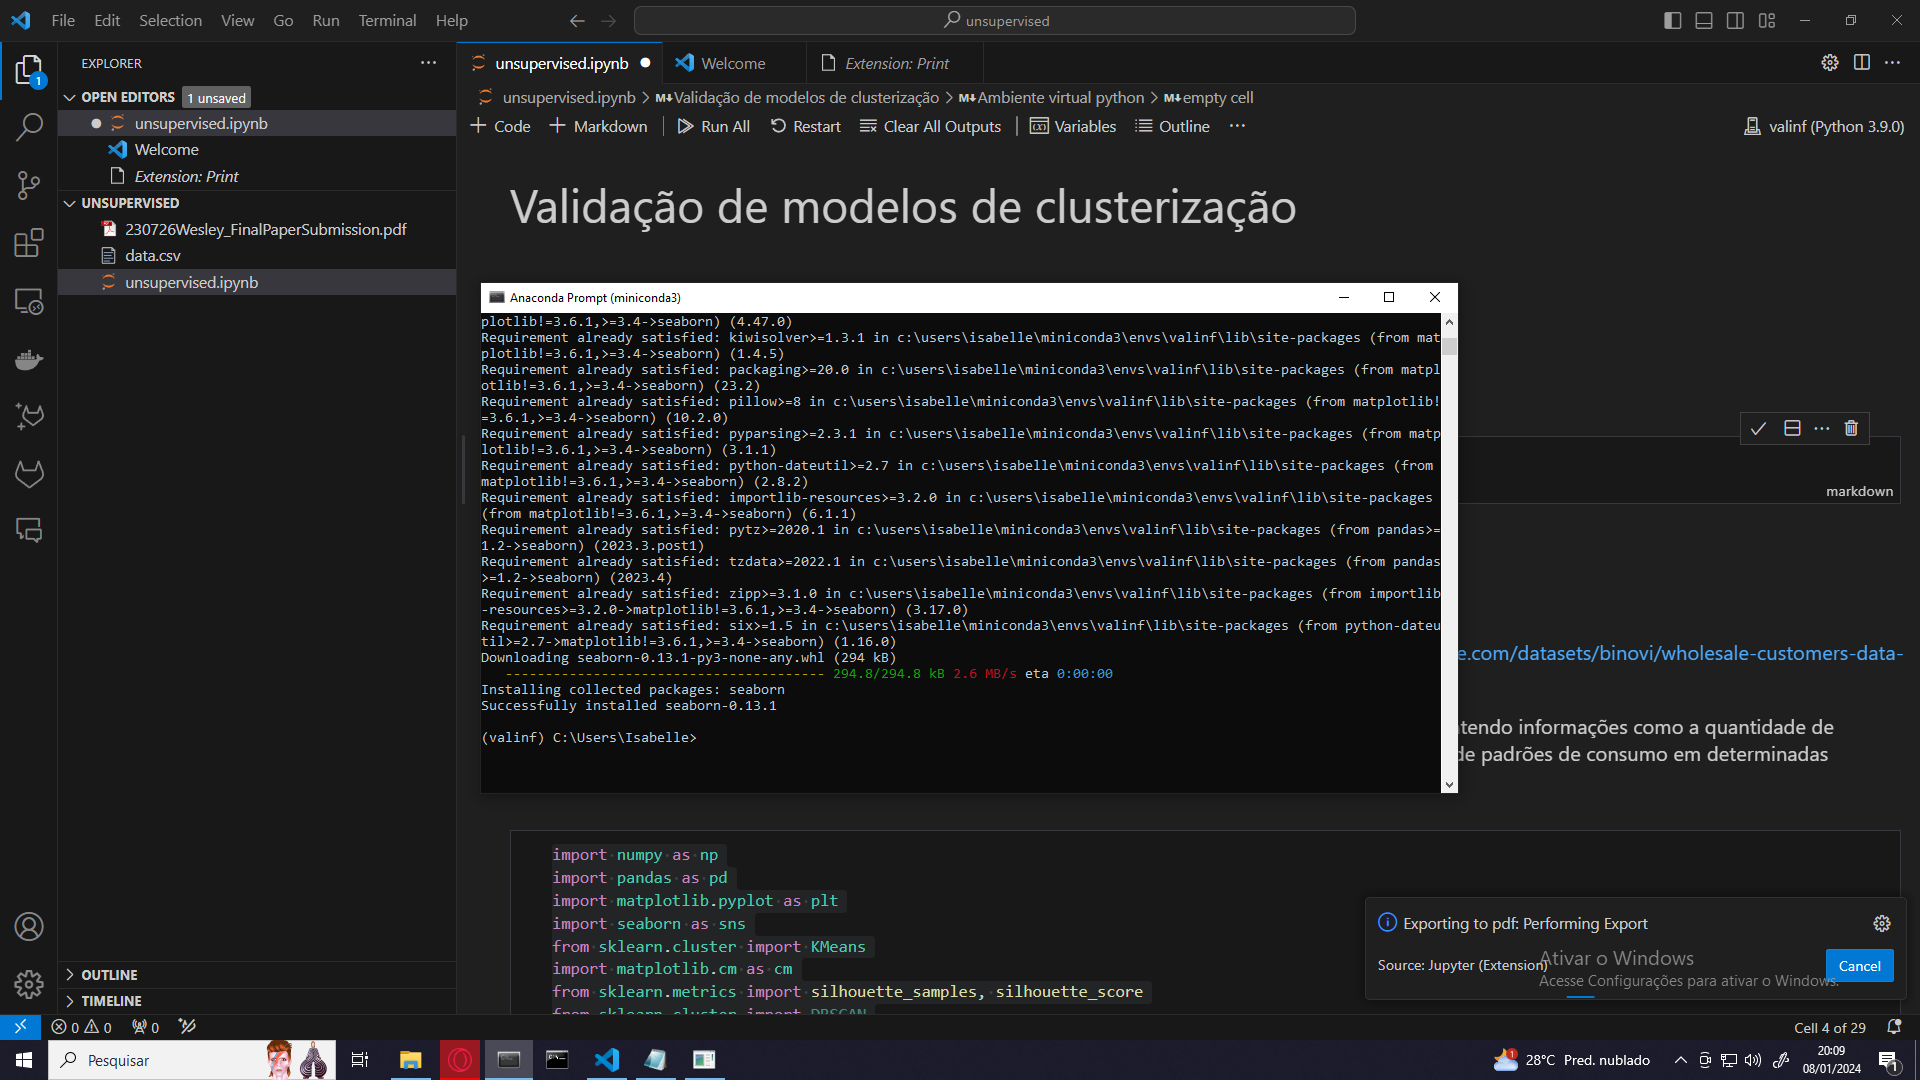

In [55]:
%matplotlib inline
from IPython.display import Image
Image('C:/Users/Isabelle/Desktop/unsupervised/Captura de Tela (149).png')

## Análise de dados

A base de dados é a Wholesale customers Data Set podendo ser encontrada no Kaggle: https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set de fácil acesso.

Esta base representa gastos anuais em unidades monetárias dos clientes de um distribuidor atacadista, contendo informações como a quantidade de produtos requisitados por região ou estabelecimento na dada região, sendo interessante para construção de padrões de consumo em determinadas localidades.

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
data = pd.read_csv("data.csv")
data.drop(labels=(['Channel','Region']),axis=1,inplace=True)

data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [4]:
print('O dataset possui {} amostras com {} features cada'.format(*data.shape))

O dataset possui 440 amostras com 6 features cada


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Fresh             440 non-null    int64
 1   Milk              440 non-null    int64
 2   Grocery           440 non-null    int64
 3   Frozen            440 non-null    int64
 4   Detergents_Paper  440 non-null    int64
 5   Delicassen        440 non-null    int64
dtypes: int64(6)
memory usage: 20.8 KB


In [5]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


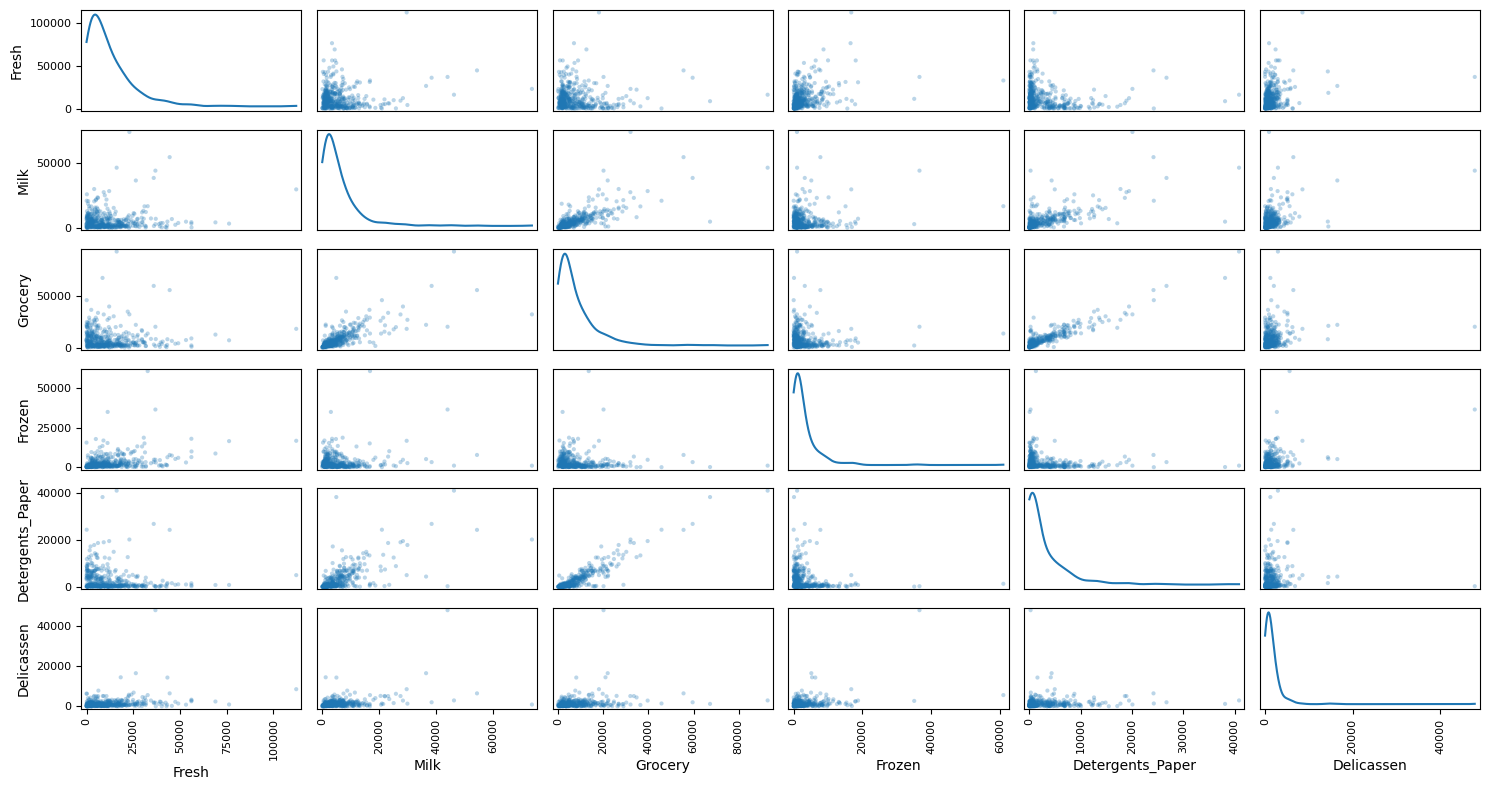

In [7]:
# Distribuicao das features

pd.plotting.scatter_matrix(data, alpha=0.3,figsize=(15,8),diagonal='kde' )
plt.tight_layout()

Podemos visualizar a faixa dinâmica das variáveis

O atributo "Milk" revelou indícios de correlação em cerca da metade das características com as quais foi comparado. Destaca-se que a maior correlação ocorre entre os atributos "Detergents_Paper" e "Grocery", o que faz sentido intuitivo, já que muitas pessoas tendem a adquirir ambos durante suas compras de supermercado. Outro ponto de destaque é a observação da quantidade de pontos em torno de zero, especialmente ao serem comparados com o atributo "Delicatessen". Os dados para todas essas características exibem uma distribuição assimétrica à direita, com muitos pontos agrupados na origem ou em suas proximidades, além de uma cauda longa.

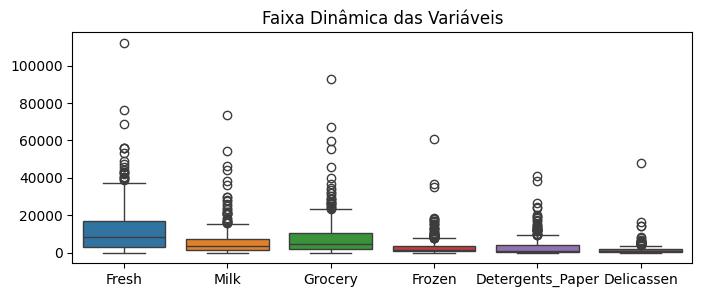

In [12]:
# Visualizando a faixa dinâmica das variáveis
plt.figure(figsize=(8, 3))
sns.boxplot(data=data)
plt.title('Faixa Dinâmica das Variáveis')
plt.show()

Há aparentes outliers nas distribuições, mas também é importante lembrar que pelos kde plots vimos que as distribuições são assimétricas, podendo indicar distribuições do tipo log-normal e estes atributos não contendo tantos outliers quanto aparentam.

## Processamento de dados

É necessário um pré-processamento para encontrar uma melhor representação dos clientes. Pode ser feito um scaling para igualar faixas de máximo e mínimo, e detecção de possíveis outliers.

O scaling (normalização) aplicado aos features do dataset é utilizado para padronizar a faixa de dados. Neste caso, como suspeitei de distribuições log-normal nos gráficos kde, podemos fazer um scaling logarítmico aplicando o log natural e verificando como fica a dsitribuição após. É esperado que as distribuições com cauda alongada se suavizem e a representação dos dados fique mais clara.

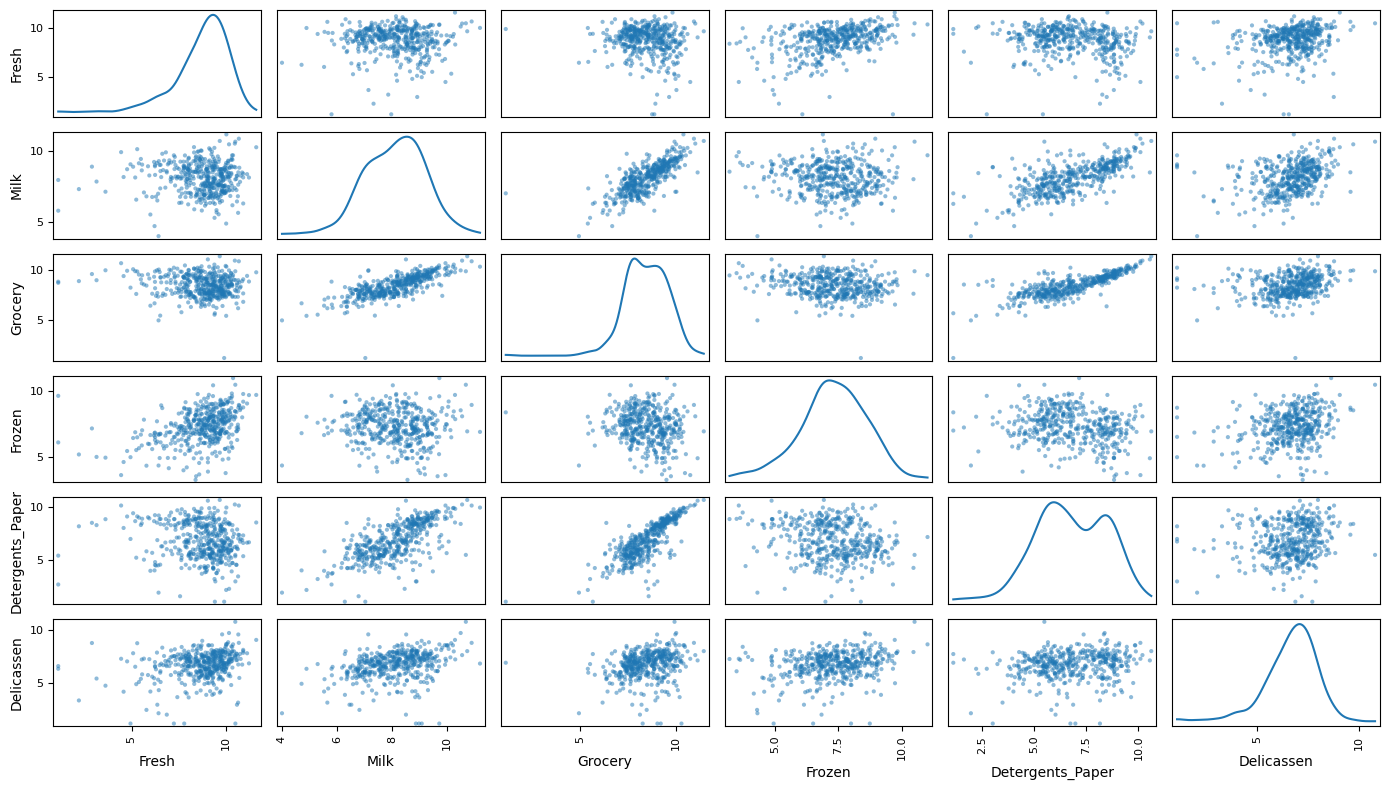

In [14]:
log_data = np.log(data.copy())

pd.plotting.scatter_matrix(log_data, alpha=0.5, figsize=(14,8),diagonal='kde')
plt.tight_layout()

Agora a distribuição de dados está mais centralizada e nos fornece melhores informações sobre as faixas das variáveis.

## Clusterização

k-médias: um método de Clustering. Ele tenta separar os dados em K clusters, dado a distância de cada ponto até o centroide. K pontos aleatórios do dataset são escolhidos para serem as coordenadas dos centroides iniciais. Desta forma, cada instância desses dados é atribuída ao centroide mais próximo. Nas demais iterações a posição dos centroides é calculada através da distancia média entre todos os pontos atribuídos àquele centroide na última iteração. O algoritmo termina quando a posição dos centroides não é mais modificada ou a distancia dessa mudança é menor que um threshold predefinido.

O índice de silhueta mede o quão bem um ponto se encaixa em um cluster. Um gráfico é feito medindo quão perto os pontos de um cluster estão dos pontos de outro cluster mais próximo. Quando próximo de +1, indica que os pontos estão muito longe dos pontos do outro cluster, e quando próximo de 0, indica que os pontos então muito perto ou até interseccionando um outro cluster.

Para seu cálculo é preciso definir a distância média de um ponto para todos os outros pontos em seu cluster e também definir a distância média até os pontos do cluster mais próximo.

Para n_clusters = 2 O score_silhouette médio é: 0.299960346830154
Para n_clusters = 3 O score_silhouette médio é: 0.25937706267780164
Para n_clusters = 4 O score_silhouette médio é: 0.1894931889218838
Para n_clusters = 5 O score_silhouette médio é: 0.20402384034589266
Para n_clusters = 6 O score_silhouette médio é: 0.20109861194730244


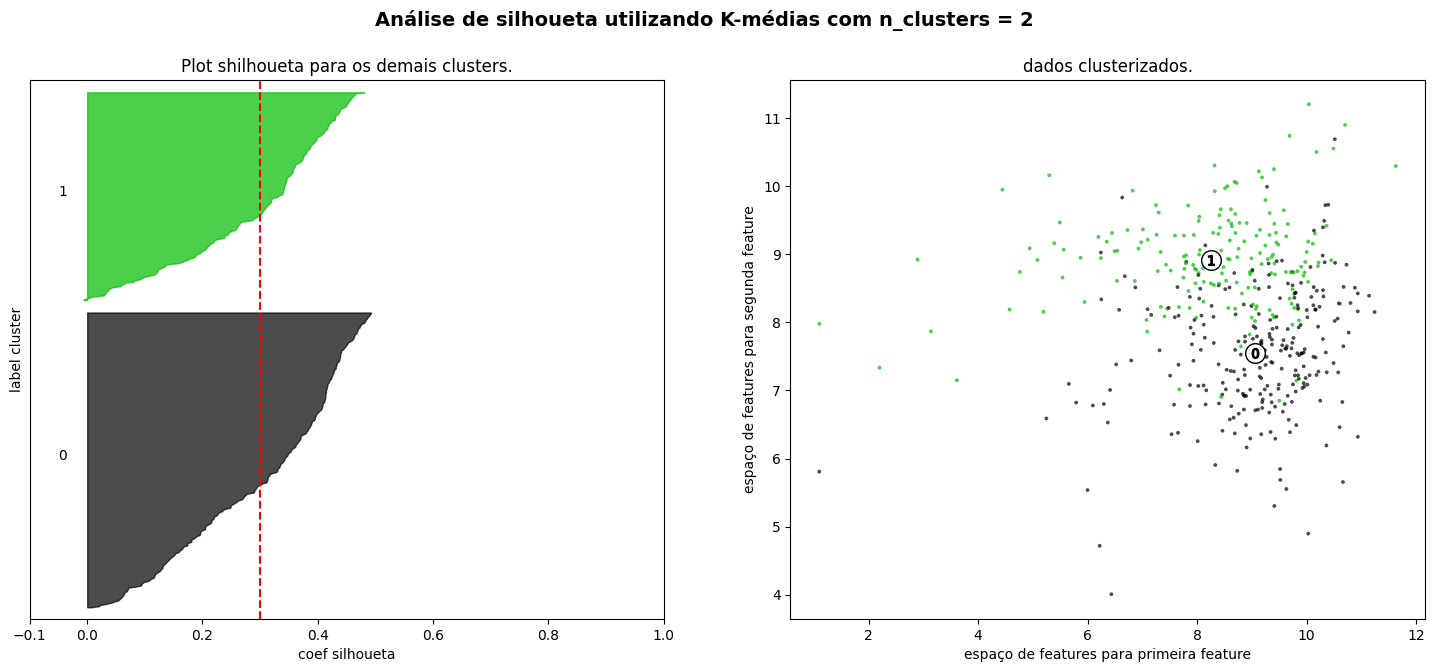

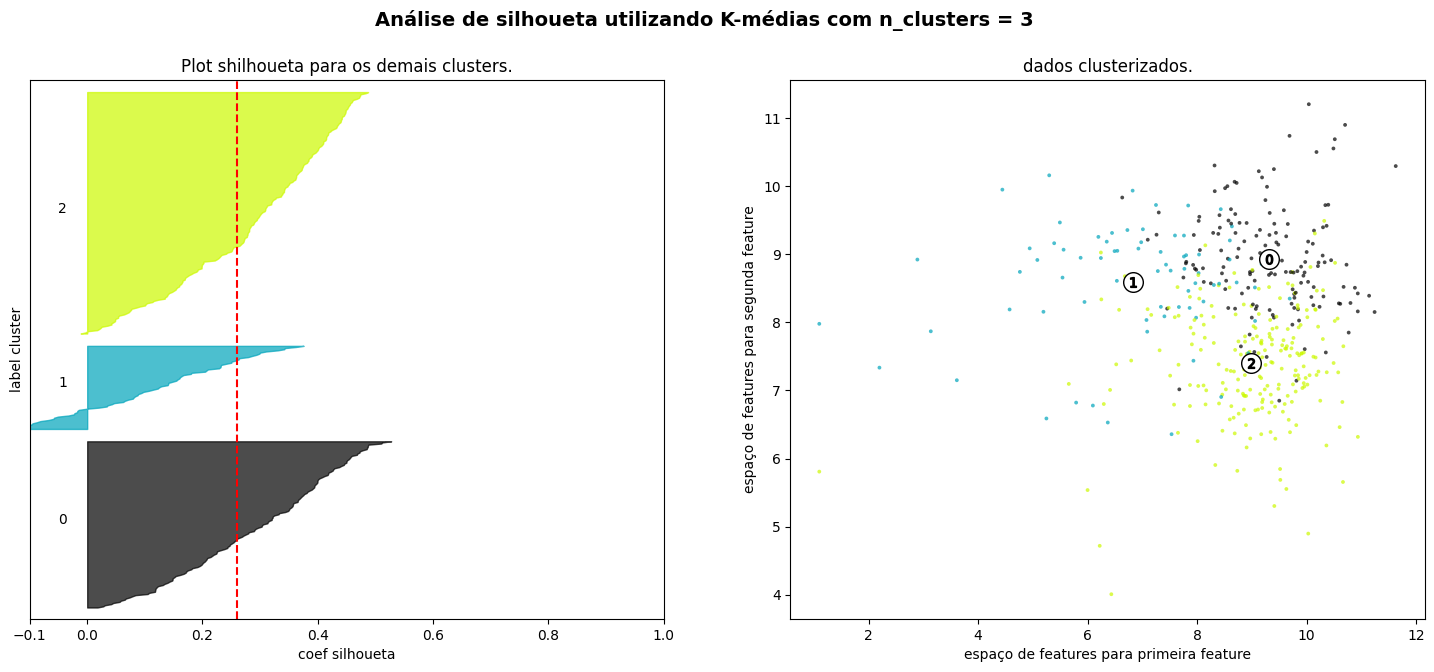

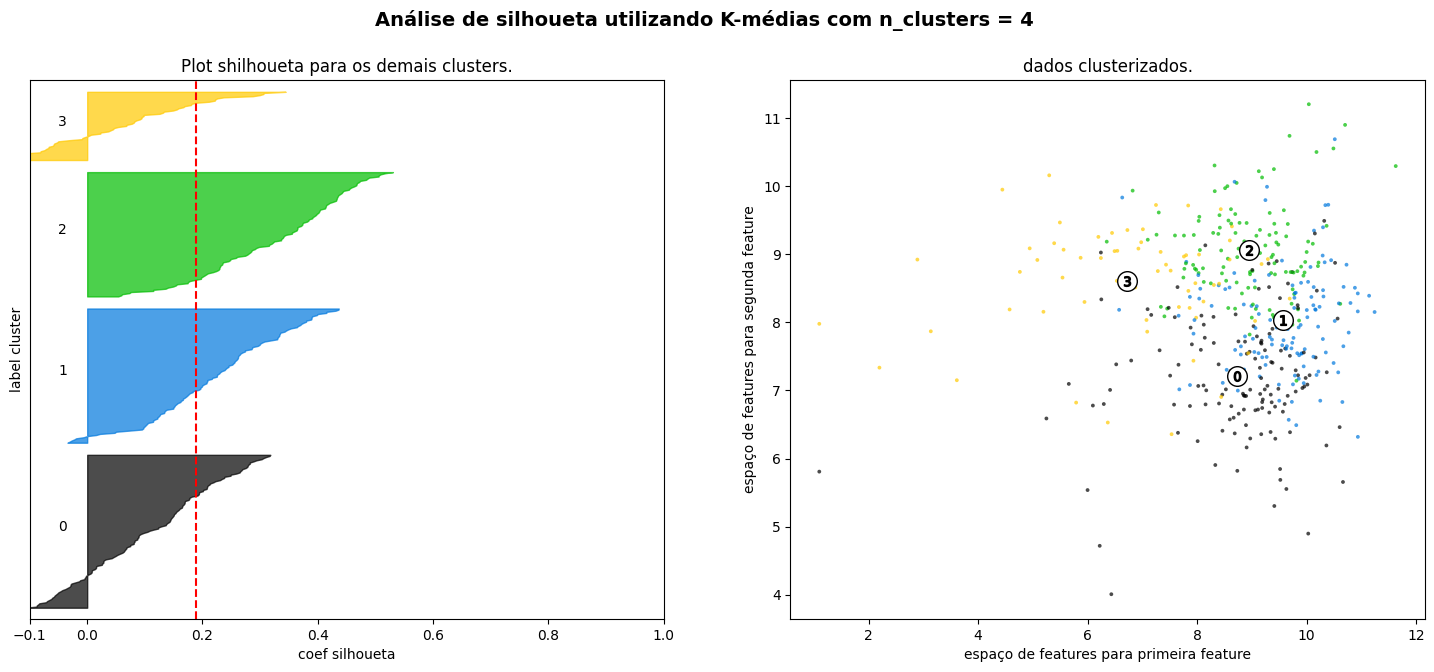

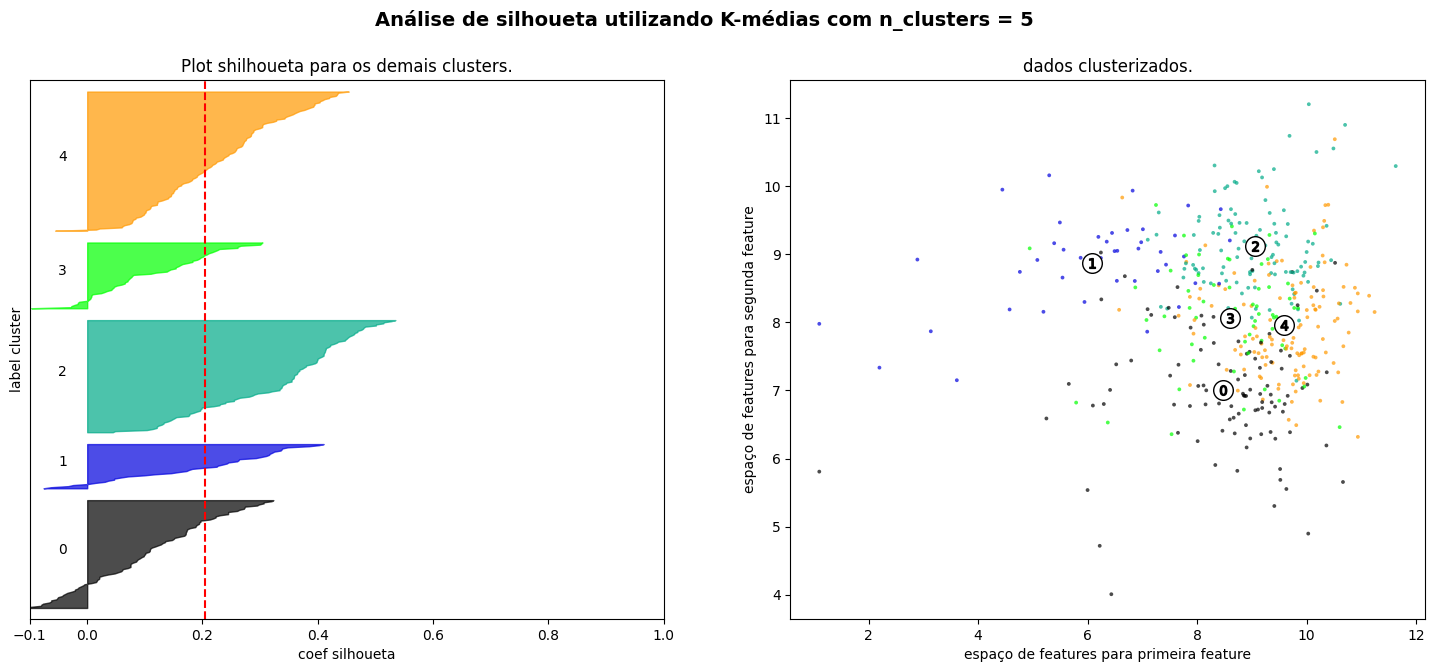

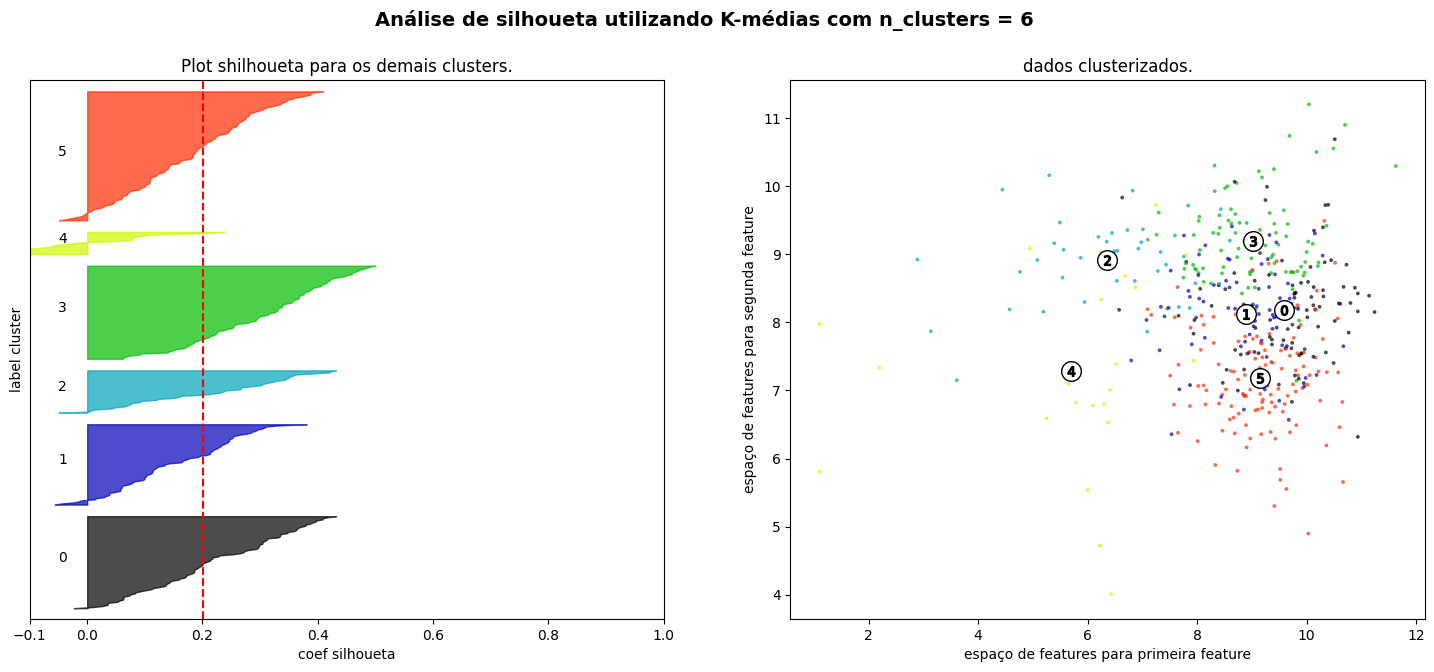

In [27]:
range_n_clusters = [2, 3, 4, 5, 6]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(log_data) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(log_data)
    
    silhouette_avg = silhouette_score(log_data, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é:", silhouette_avg)
    
    sample_silhouette_values = silhouette_samples(log_data, cluster_labels)
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    
    ax1.set_title("Plot shilhoueta para os demais clusters.")
    ax1.set_xlabel("coef silhoueta")
    ax1.set_ylabel("label cluster")
    
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
    ax2.scatter(log_data.iloc[:, 0], log_data.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    
    ax2.set_title("dados clusterizados.")
    ax2.set_xlabel("espaço de features para primeira feature")
    ax2.set_ylabel("espaço de features para segunda feature")
    
    plt.suptitle(("Análise de silhoueta utilizando K-médias "
                  "com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

É possível verificar que pelos gráficos e os coeficientes encontrados, os clusters aparentemente mais bem separados se encontram com a divisão de 2 ou 3 clusters.

DBScan: O DBSCAN (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de agrupamento que se baseia na densidade dos dados em vez de assumir formas geométricas específicas dos clusters. Duas principais configurações de parâmetros no DBSCAN são eps (distância máxima entre dois pontos para um deles ser considerado no vizinho do outro) e min_samples (o número mínimo de pontos necessários para formar um cluster).

O parâmetro eps controla a proximidade necessária para que um ponto seja considerado parte de um cluster. Valores mais altos de eps aumentam a distância para formar conexões entre pontos, resultando em clusters maiores e potencialmente incorporando mais pontos. Por outro lado, valores mais baixos de eps podem levar a clusters menores e mais densos.

O parâmetro min_samples define a quantidade mínima de pontos em uma vizinhança para que um ponto seja considerado um ponto central. A presença de core points é crucial para a formação de clusters. Um valor mais alto de min_samples exige uma densidade mais alta para formar clusters, enquanto um valor mais baixo pode permitir a criação de clusters com menos pontos.

A combinação adequada de eps e min_samples é essencial para extrair agrupamentos significativos nos dados, evitando a classificação incorreta de pontos como ruído ou a formação de clusters não representativos. Experimentar diferentes valores desses parâmetros é uma prática comum para otimizar o desempenho do DBSCAN em conjunto com a análise do coeficiente de silhueta, proporcionando insights sobre a qualidade dos clusters formados.

In [53]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
import numpy as np

X = log_data

eps_values = [1, 2.5, 3, 4,]
min_samples_values = [1, 2, 5, 10]

for eps_value in eps_values:
    for min_samples_value in min_samples_values:
        clustering = DBSCAN(eps=eps_value, min_samples=min_samples_value).fit(X)
        
        labels = clustering.labels_
        
        core_samples = np.zeros_like(labels, dtype=bool)
        core_samples[clustering.core_sample_indices_] = True
        
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        print("eps =", eps_value, "min_samples =", min_samples_value)
        print("Clusters:", n_clusters_)
        
        silhouette_score = metrics.silhouette_score(X, labels)
        print("coef sihloueta:", silhouette_score)
        print("-" * 50)


eps = 1 min_samples = 1
Clusters: 195
coef sihloueta: -0.21616959509410674
--------------------------------------------------
eps = 1 min_samples = 2
Clusters: 27
coef sihloueta: -0.34933850972199376
--------------------------------------------------
eps = 1 min_samples = 5
Clusters: 7
coef sihloueta: -0.18501683299269545
--------------------------------------------------
eps = 1 min_samples = 10
Clusters: 3
coef sihloueta: -0.24343167702148533
--------------------------------------------------
eps = 2.5 min_samples = 1
Clusters: 16
coef sihloueta: 0.04986222549246836
--------------------------------------------------
eps = 2.5 min_samples = 2
Clusters: 2
coef sihloueta: 0.32260297398765375
--------------------------------------------------
eps = 2.5 min_samples = 5
Clusters: 1
coef sihloueta: 0.4418267824005676
--------------------------------------------------
eps = 2.5 min_samples = 10
Clusters: 1
coef sihloueta: 0.4264081064006622
--------------------------------------------------


O output mostra que uma interação interessante pode ser a de:

eps = 2.5 min_samples = 2
Clusters: 2
coef sihloueta: 0.32260297398765375

Com 2 clusters formados. Isso possui uma similaridade com o resultado encontrado por K-médias em que o ideal seriam 2 ou 3 clusters. Entretanto, os coeficientes de silhoueta de ambos são diferentes e no DBScan não se define o número de clusters previamente. 

Os valores mais próximos de 1 de sihloueta são valores para clusters definidos como 1 cluster total, o que indica que possivelmente não é interessante utilizar essa medida como uma referência para indicar o número ótimo de clusters. À medida que se aumenta o eps, o silhoueta aumenta para mais próximo de 1 e o número ótimo de clusters vai diminuindo.

## Medidas de similaridade

Para agrupar 10 séries temporais distintas em 3 grupos, conforme um critério de similaridade fundamentado no valor máximo de correlação cruzada entre elas, os seguintes passos podem ser seguidos:

- Para o pré-processamento: Carregar as séries temporais garantindo alinhamento temporal e tratar dados ausentes por meio de preenchimento

- Para o cálculo da correlação cruzada: Determinar a correlação cruzada entre todas as combinações possíveis, utilizando métricas como a correlação de Pearson

- Para identificação de valor máximo de correlação: Encontrar o ponto de defasagem que resulta no valor máximo de correlação cruzada para cada par de séries temporais

- Para K-médias/agrupamento hierárquico (clusterização): Aplicar algoritmos de clusterização hierárquica ou K-médias para agrupar as séries com base nos valores máximos de correlação e escolher o número desejado de clusters (nesse caso pode ser feito o teste com 3)

- Para visualização e análise: Visualizar os grupos formados e analisar as características das séries temporais em cada grupo e validar a robustez do agrupamento considerando outras métricas de avaliação

- Para a interpretação e aplicações: Interpretar os resultados, considerando a similaridade máxima entre as séries temporais no mesmo grupo e explorar possíveis aplicações práticas dos grupos identificados

- Quanto à escolha do algoritmo de clusterização, sugere-se o uso do K-Médias ou Hierárquico. Ambos são eficazes para agrupar dados com base em distâncias ou similaridades. O K-Médias pode ser especialmente útil quando a correlação cruzada é a métrica principal, enquanto o agrupamento hierárquico proporciona uma visão hierárquica da estrutura dos clusters. Um caso de uso potencial para essa abordagem seria o monitoramento de desempenho, onde as séries temporais representam métricas diárias. Os grupos formados podem revelar padrões sazonais ou semanais similares, auxiliando em estratégias de otimização. Além disso, uma alternativa interessante para medir a similaridade entre séries temporais seria a aplicação do algoritmo Dynamic Time Warping (DTW), que leva em conta distorções temporais entre as séries